# loading data

loads data in a dictionary with 4 labels and normalise it (or normalise it later)

In [2]:
import os
import scipy.io
import numpy as np

raw_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}
raw_val_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}

training_dir = os.path.join('..', 'data', 'training')
validation_dir = os.path.join('..', 'data', 'validation')

for Dir in [training_dir, validation_dir]:
    for Class in ['normal', 'af', 'other', 'noisy']:
        class_dir = os.path.join(Dir, Class)
        for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
            mat_data = scipy.io.loadmat(file)
            sequence = mat_data['val'][0]
            n_sequence = sequence
            
            if Dir == training_dir:
                raw_data[Class].append(n_sequence)
            else:
                raw_val_data[Class].append(n_sequence)

In [3]:
from scipy.signal import butter,filtfilt
import math

def butter_lowpass_filter(data, cutoff):
    T = 10         # Sample Period
    fs = 150      # sample rate, Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2
    n = int(T * fs) # total number of samples

    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def length_transfrom(x, w):
    fs = 300
    tmp = []
    for i in range(w, len(x)):
        curr = 0
        for k in range(i-w+1, i):
            curr += np.sqrt((20/fs)+np.power(x[k]-x[k-1],2))
        tmp.append(curr)
    l = [tmp[0]]*w
    
    return l+tmp

def threshold(x):
    u = np.mean(x)
    peaks = []
    fs = 300
    for i in range(len(x)):
        if (len(peaks) == 0 or i > peaks[-1]+(fs*0.18)) and x[i] > u:
            peaks.append(i)
    return peaks

def _wqrs(x):
    fs = 50
    y = butter_lowpass_filter(x, 15)
    y = length_transfrom(y, math.ceil(fs*.130))
    return threshold(y)

## pre-processing


In [9]:
train_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}
val_data = {'normal': [], 'af': [], 'other': [], 'noisy': []}

sampling_freq = 300
down_freq = 300
window_size = 5

R = sampling_freq // down_freq

for idx, data in enumerate([train_data, val_data]):
    for key in data.keys():
        tmp = raw_data if idx == 0 else raw_val_data
        for d in tmp[key]:
            for i in range(0, len(d)+window_size*(sampling_freq), window_size*(sampling_freq)):
                if i+(window_size*(sampling_freq)) <= len(d):
                    sequence = d[i:i+window_size*(sampling_freq)]
                    normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
                    data[key].append(normalised_sequence)                
                elif i < len(d):
                    sequence = d[i:]
                    sequence = np.pad(sequence, (0, window_size*sampling_freq-len(sequence)), 'reflect')
                    normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
                    data[key].append(normalised_sequence)
                data[key][-1] = data[key][-1].reshape(-1, R).mean(axis=1)
                                
train_data['normal'] = train_data['normal'][:725]
train_data['af'] = train_data['af'][:425]
train_data['other'] = train_data['other'][:300]
train_data['noisy'] = train_data['noisy'][:1450]

val_data['normal'] = val_data['normal'][:100]
val_data['af'] = val_data['af'][:40]
val_data['other'] = val_data['other'][:30]
val_data['noisy'] = val_data['noisy'][:170]

In [10]:
for data in [train_data, val_data]:
    print('-----\n')
    print('normal:', len(data['normal']))
    print('af:', len(data['af']))
    print('other:', len(data['other']))
    print('noisy:', len(data['noisy']), '\n')
    print('total:', len(data['normal']) + len(data['af']) + len(data['other']) + len(data['noisy']))


-----

normal: 725
af: 425
other: 300
noisy: 1450 

total: 2900
-----

normal: 100
af: 40
other: 30
noisy: 160 

total: 330


In [15]:
!pip3 install py-ecg-detectors --upgrade

  Attempting uninstall: py-ecg-detectors
    Found existing installation: py-ecg-detectors 1.1.0
    Uninstalling py-ecg-detectors-1.1.0:
      Successfully uninstalled py-ecg-detectors-1.1.0


In [11]:
import pandas as pd
from tqdm import tqdm
from ecgdetectors import Detectors
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import skew, kurtosis

def get_SQIs(x, target=0):
    fs = 300
    sSQI = skew(x, bias=False)
    kSQI = kurtosis(x, fisher=False, bias=False)
    
    def get_first_idx(x, a):
        for i in range(len(x)):
            if x[i] >= a:
                    return i

    def get_last_idx(x, a):
        for i in range(len(x)):
            if x[i] >= a:
                return i-1
                
    f, Pxx_den = welch(x, fs=300)
    u1 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 15)], x=f[get_first_idx(f, 5):get_last_idx(f, 15)])
    u2 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 40)], x=f[get_first_idx(f, 5):get_last_idx(f, 40)])
    u3 = simps(Pxx_den[get_first_idx(f, 1):get_last_idx(f, 40)], x=f[get_first_idx(f, 1):get_last_idx(f, 40)])
    u4 = simps(Pxx_den[get_first_idx(f, 0):get_last_idx(f, 40)], x=f[get_first_idx(f, 0):get_last_idx(f, 40)])

    pSQI = (u1/u2)
    basSQI = (u3/u4)
            
    detectors = Detectors(down_freq)
    
    wqrs = _wqrs(x)
    eplimited = detectors.hamilton_detector(x)
    count = 0
    j = 0
    k = 0
    while j < len(wqrs) and k < len(eplimited):
        if wqrs[j] >= eplimited[k]-0.13*fs and wqrs[j] <= eplimited[k]+0.13*fs:
            count += 1
            j+=1
            k+=1
        elif wqrs[j] > eplimited[k]:
            k+=1
        else:
            j+=1

    bSQI = (count/len(wqrs))
    rSQI = (len(wqrs)/(len(wqrs)+len(eplimited)))
    
    return [sSQI, kSQI, pSQI, basSQI, bSQI, rSQI, target]

train_table = pd.DataFrame(columns=['sSQI','kSQI','pSQI','basSQI','bSQI','rSQI', 'target'])
count = 0
for Class in train_data:
    target = 1 if Class == 'noisy' else 0
    for i in tqdm(range(len(train_data[Class]))):
        train_table.loc[count] = get_SQIs(train_data[Class][i], target)
        count += 1
train_table.head()

100%|██████████| 1450/1450 [01:09<00:00, 20.87it/s]


,sSQI,kSQI,pSQI,basSQI,bSQI,rSQI,target
0,1.591682,10.180201,0.677330,0.893694,0.857143,0.500000,0.0
1,3.487843,16.106743,0.654026,0.946995,0.750000,0.533333,0.0
2,4.131124,21.910001,0.692541,0.945470,1.000000,0.461538,0.0
3,4.161843,22.181034,0.647306,0.947311,1.000000,0.500000,0.0
4,4.023904,20.403193,0.686688,0.937579,0.857143,0.538462,0.0


In [12]:
sSQI_u = train_table['sSQI'].mean() 
kSQI_u = train_table['kSQI'].mean() 

sSQI_var = train_table['sSQI'].var() 
kSQI_var = train_table['kSQI'].var() 

train_table['sSQI'] = train_table['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
train_table['kSQI'] = train_table['kSQI'].apply(lambda x: (x-kSQI_u) / np.sqrt(kSQI_var))

In [ ]:
val_table = pd.DataFrame(columns=['sSQI','kSQI','pSQI','basSQI','bSQI','rSQI', 'target'])
count = 0
for Class in val_data:
    target = 1 if Class == 'noisy' else 0
    for i in tqdm(range(len(val_data[Class]))):
        val_table.loc[count] = get_SQIs(val_data[Class][i], target)
        count += 1

 27%|██▋       | 43/160 [00:02<00:05, 20.60it/s]

In [29]:
val_table['sSQI'] = val_table['sSQI'].apply(lambda x: (x-sSQI_u) / np.sqrt(sSQI_var))
val_table['kSQI'] = val_table['kSQI'].apply(lambda x: (x-kSQI_u) / np.sqrt(kSQI_var))

val_table.head()

print(sSQI_u, kSQI_u)
print(sSQI_var, kSQI_var)

0.6830722445870502 10.285655554509132
4.275985485144306 131.0073065212058


# SVM 


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load

x_train = train_table.drop(['target'], axis='columns')
y_train = train_table.target

x_test = val_table.drop(['target'], axis='columns')
y_test = val_table.target


model = SVC(C=25, gamma=1, probability=True)
model.fit(x_train, y_train)
dump(model, 'model_2_03_21_5s.joblib');

0.8636363636363636


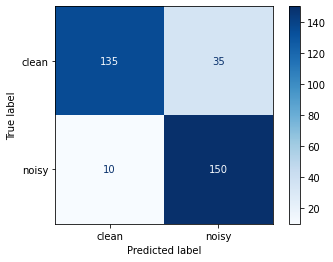

In [31]:
import matplotlib.pyplot as plt
print(model.score(x_test, y_test))
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['clean', 'noisy'])
disp.plot(cmap=plt.cm.Blues)


In [264]:
errors = y_test[model.predict(x_test) != y_test]